In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

#from xscale import signal
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:107: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [3]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_anom_fw.nc').budg_fw
budgH = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_anom_heat.nc').budgH

In [4]:
budgFw_int = (budgFw.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
budgH_int = (budgH.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')

In [5]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
budgH_anom = budgH_int - budgH_int.mean('time')

### Plot

In [6]:
class OffsetYearLocator(dates.YearLocator):
    def __init__(self, *args, **kwargs):
        self.offset = kwargs.pop("offset", 0)
        dates.YearLocator.__init__(self,*args, **kwargs)
    def tick_values(self, vmin, vmax):
        ymin = self.base.le(vmin.year) * self.base.step - self.offset
        ymax = self.base.ge(vmax.year) * self.base.step + (self.base.step-self.offset)
        ticks = [vmin.replace(year=ymin, **self.replaced)]
        while True:
            dt = ticks[-1]
            if dt.year >= ymax:
                return dates.date2num(ticks)
            year = dt.year + self.base.step
            ticks.append(dt.replace(year=year, **self.replaced))

def format_xaxis(ax):

    years = dates.YearLocator(10,month=1,day=1)
    years1=OffsetYearLocator(2,month=1,day=1, offset=1)
    dfmt = dates.DateFormatter('%Y')
    dfmt1 = dates.DateFormatter('%y')

    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_minor_locator(years1)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_formatter(dfmt1)
    ax.get_xaxis().set_tick_params(which='major', pad=15)

    plt.setp(ax.get_xmajorticklabels(), rotation=0, weight="bold", ha="center")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


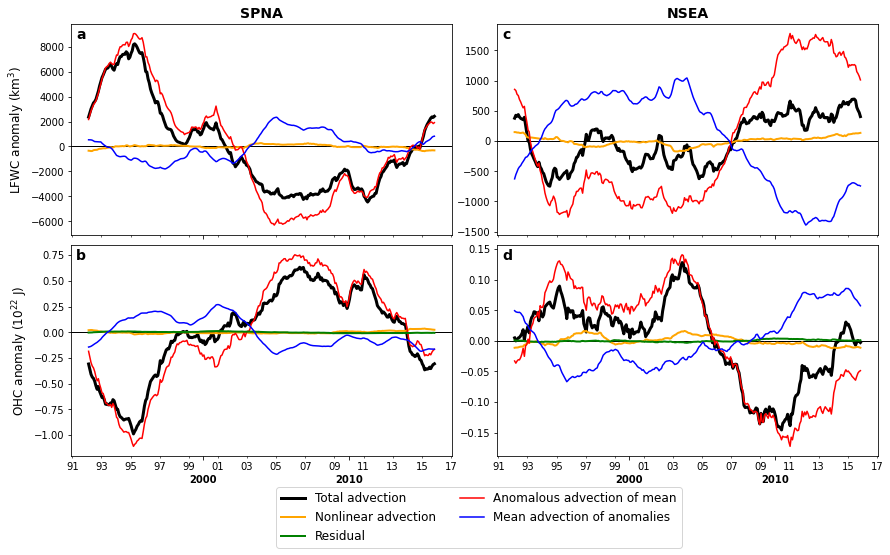

In [8]:
fig, axs = plt.subplots(2, 2,sharex=True, figsize=(14, 8))

axs[0,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_ConvFw')*1e-3, 
              lw=3, color='black',label='Total advection')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_Uanom_FWanom')*1e-3, 
              lw=2, color='orange',label='Nonlinear advection')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_Uanom_FWclim')*1e-3, 
              lw=1.5, color='red',label='Anomalous advection of mean')
axs[0,0].plot(budgFw_anom.time, budgFw_anom.sel(region='spna',term='adv_Uclim_FWanom')*1e-3, 
              lw=1.5, color='blue',label='Mean advection of anomalies')
axs[0,0].set_ylabel(r'LFWC anomaly (km$^3$)',fontsize=12)
axs[0,0].text(0.013,0.93, 'a', fontsize=14, fontweight='bold', transform=axs[0,0].transAxes)
axs[0,0].set_title(r'SPNA', fontsize=14, fontweight='bold')

axs[1,0].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_ConvH')*1e-22, 
              lw=3, color='black',label='Total advection')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_Uanom_Tanom')*1e-22, 
              lw=2, color='orange',label='Nonlinear advection')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_Uanom_Tclim')*1e-22, 
              lw=1.5, color='red',label='Anomalous advection of mean')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='resH')*1e-22, 
              lw=2, color='green',label='Residual')
axs[1,0].plot(budgH_anom.time, budgH_anom.sel(region='spna',term='adv_Uclim_Tanom')*1e-22, 
              lw=1.5, color='blue',label='Mean advection of anomalies')
axs[1,0].set_ylabel(r'OHC anomaly (10$^{22}$ J)', fontsize=12)
axs[1,0].text(0.013,0.93, 'b', fontsize=14, fontweight='bold', transform=axs[1,0].transAxes)
format_xaxis(axs[1,0])

axs[0,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_ConvFw')*1e-3, 
              lw=3, color='black',label='Total advection')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_Uanom_FWanom')*1e-3, 
              lw=2, color='orange',label='Nonlinear advection')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_Uanom_FWclim')*1e-3, 
              lw=1.5, color='red',label='Anomalous advection of mean')
axs[0,1].plot(budgFw_anom.time, budgFw_anom.sel(region='nsea',term='adv_Uclim_FWanom')*1e-3, 
              lw=1.5, color='blue',label='Mean advection of anomalies')

axs[0,1].text(0.013,0.93, 'c', fontsize=14, fontweight='bold', transform=axs[0,1].transAxes)
axs[0,1].set_title(r'NSEA', fontsize=14, fontweight='bold')

axs[1,1].axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_ConvH')*1e-22, 
              lw=3, color='black',label='Total advection')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_Uanom_Tanom')*1e-22, 
              lw=2, color='orange',label='Nonlinear advection')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='resH')*1e-22, 
              lw=2, color='green',label='Residual')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_Uanom_Tclim')*1e-22, 
              lw=1.5, color='red',label='Anomalous advection of mean')
axs[1,1].plot(budgH_anom.time, budgH_anom.sel(region='nsea',term='adv_Uclim_Tanom')*1e-22, 
              lw=1.5, color='blue',label='Mean advection of anomalies')

axs[1,1].text(0.013,0.93, 'd', fontsize=14, fontweight='bold', transform=axs[1,1].transAxes)
format_xaxis(axs[1,1])
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.15, top=0.9, hspace=0.05, wspace=0.12)
axs[1,1].legend(frameon=True, fancybox=True, bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


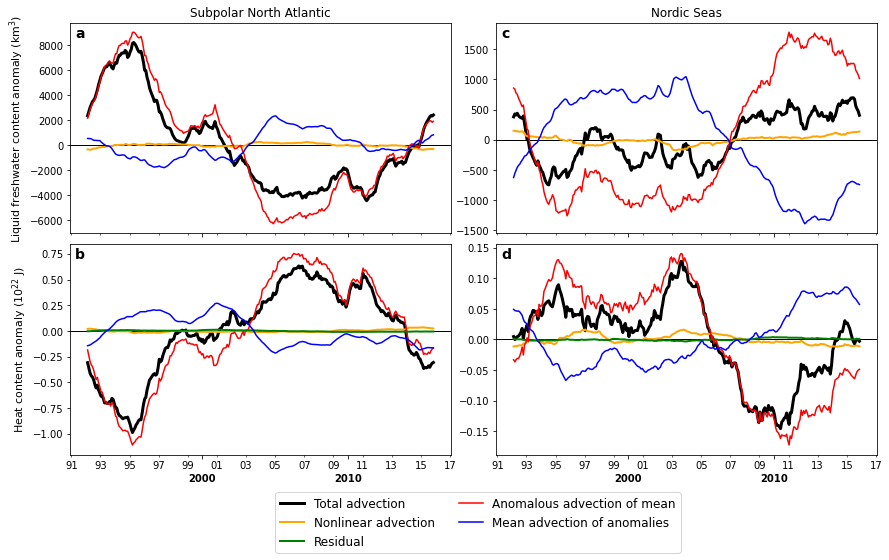

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


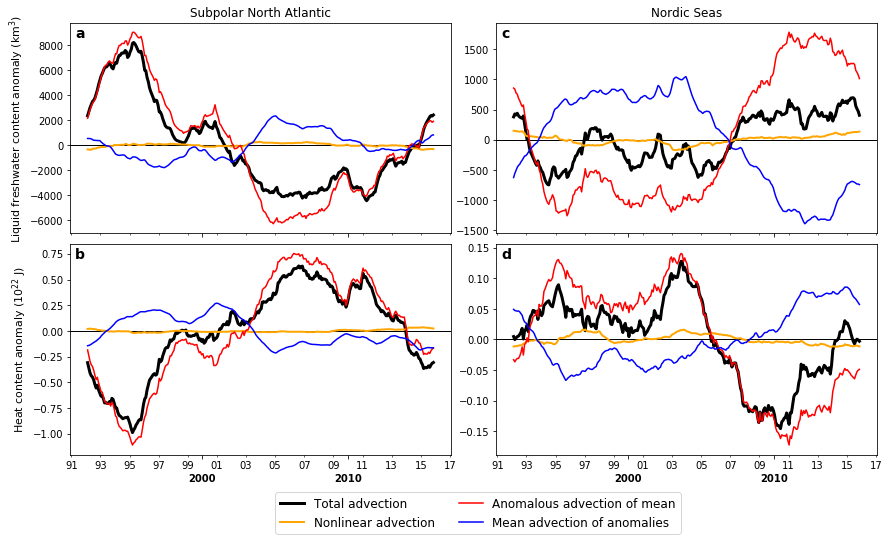